ML_Assignment1
Aanjaney Kumar Verma : 2019UCS0085

In [144]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

visitors_df= pd.read_csv("https://raw.githubusercontent.com/Akuver/ML_Lab/main/changes-visitors-covid.csv")
covid_df = pd.read_csv("https://raw.githubusercontent.com/Akuver/ML_Lab/main/covid-data.csv")

In [145]:
target_country="India"
visitors_df = visitors_df.loc[visitors_df["Entity"]==target_country]
covid_df = covid_df.loc[covid_df["location"]==target_country]

In [146]:
visitors_df.head(5)

,Entity,Code,Day,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
23897,India,IND,2020-02-17,0.667,1.667,0.000,2.000,3.000,3.000
23898,India,IND,2020-02-18,0.500,1.750,0.000,2.000,3.250,3.000
23899,India,IND,2020-02-19,0.400,1.800,0.200,1.800,2.800,3.200
23900,India,IND,2020-02-20,0.500,2.000,0.000,2.333,3.167,3.333
23901,India,IND,2020-02-21,-0.143,1.714,0.714,1.429,3.571,0.143


In [96]:
columns = ['location','date','new_cases']
covid_df=covid_df[columns]
covid_df.head(5)

,location,date,new_cases
38584,India,2020-01-30,1.0
38585,India,2020-01-31,0.0
38586,India,2020-02-01,0.0
38587,India,2020-02-02,1.0
38588,India,2020-02-03,1.0


In [97]:
visitors_df.loc['Day']=pd.to_datetime(visitors_df['Day'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [98]:
covid_df.loc['date'] = pd.to_datetime(covid_df['date'])

In [99]:
visitors_df.rename(columns = {'Day':'date'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [100]:
df = visitors_df.merge(covid_df,how='inner',on=['date'])
df.head(5)

,Entity,Code,date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,location,new_cases
0,India,IND,2020-02-17,0.667,1.667,0.0,2.0,3.0,3.0,India,0.0
1,India,IND,2020-02-18,0.5,1.75,0.0,2.0,3.25,3.0,India,0.0
2,India,IND,2020-02-19,0.4,1.8,0.2,1.8,2.8,3.2,India,0.0
3,India,IND,2020-02-20,0.5,2.0,0.0,2.333,3.167,3.333,India,0.0
4,India,IND,2020-02-21,-0.143,1.714,0.714,1.429,3.571,0.143,India,0.0


In [101]:
df.dropna(inplace=True)

In [102]:
df=df.drop(columns=["Entity","Code","location"])

In [103]:
col = list(df.columns)
col.remove('date')
df[col] = df[col].astype(float)
df.drop(columns = ['date'],inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 0 to 470
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   retail_and_recreation  471 non-null    float64
 1   grocery_and_pharmacy   471 non-null    float64
 2   residential            471 non-null    float64
 3   transit_stations       471 non-null    float64
 4   parks                  471 non-null    float64
 5   workplaces             471 non-null    float64
 6   new_cases              471 non-null    float64
dtypes: float64(7)
memory usage: 29.4 KB


In [104]:
def mse(y, y_predict) :
  return np.mean((y-y_predict)**2)

In [105]:
# ID3-A
class ID3_A_regressor:
    def __init__(self):
      self.dec_tree = dict()
      self.depth = 0

    def fit(self, input_features, target_variable,max_depth=float('inf'),min_sdr=0,min_instances=15):
      data = input_features.copy()
      data[target_variable.name] = target_variable
      
      self.depth =0

      self.dec_tree = dict()
      self.dec_tree = self.decision_tree(data,data,target_variable.name,max_depth,min_sdr,min_instances)

    def SDR(self,input_data, feature_name,feature_value, target_name):
      #calculate the standard deviation reduction for a particular feature value

        if not pd.api.types.is_numeric_dtype(input_data[feature_name]):
            return None
        parent_sd = np.std(input_data[target_name])
        
        mask = input_data[feature_name]<=feature_value
        
        class_1 = input_data[mask]
        class_2 = input_data[~mask]
        
        prob_1 = class_1.shape[0]/(class_1.shape[0]+class_2.shape[0])
        prob_2 = 1-prob_1
        
        weighted_sd =np.std(class_1[target_name])*prob_1+np.std(class_2[target_name])*prob_2

        return parent_sd - weighted_sd
    
    def feature_split_point(self,input_data, feature_name,target_name):
        
        inp_df = input_data.sort_values(by=feature_name)
        unique_val = inp_df[feature_name].unique()

        #mean of adjacent values array 
        split_candidates = [(unique_val[i] + unique_val[i+1])/2 for i in range(unique_val.shape[0]-1)]
        
        sdr_max = -1
        best_split_value = None
        
        for value in split_candidates :
            sdr= self.SDR(inp_df,feature_name,value,target_name)
            if sdr>sdr_max :
                sdr_max = sdr
                best_split_value = value
                
        return best_split_value,sdr_max
      
    def best_split(self,input_data,target_name):
      #function to calulate the best_split point for any sub-dataset
      best_feature = None
      best_split_val = None
      best_sdr = -1

      features = list(input_data.columns)
      features.remove(target_name)

      for feature in features:  
        split_val, sdr = self.feature_split_point(input_data,feature,target_name)

        if sdr>0 and sdr>best_sdr : 
          best_sdr = sdr
          best_split_val = split_val
          best_feature = feature

      return best_feature,best_split_val,best_sdr
    
    def split_data(self,input_data,feature_name,feature_value):
      #split the data into two halfs depending on the feature value
      
      if feature_name in input_data.columns : 
        mask = input_data[feature_name]<=feature_value
        lhs_data = input_data[mask]
        rhs_data = input_data[~mask]

        return lhs_data,rhs_data
      else:
        return None
    
    def decision_tree(self, input_data, original_data,target_name,max_depth=float('inf'),curr_depth=0,min_instances=0,min_sdr=0, parent_node_mean = None):
       
        
        self.depth = max(self.depth,curr_depth)
        if len(input_data)==0:
          return np.mean(original_data[target_name])

        elif len(input_data) <= min_instances :
          return np.mean(input_data[target_name])
        
        elif len(input_data.columns)==0 or curr_depth == max_depth :
          return parent_node_mean

        else:
          parent_node_mean = np.mean(input_data[target_name])  
          
          best_feature,best_split_val,best_sdr = self.best_split(input_data,target_name)
          
          if best_feature is not None:  
            if best_sdr <min_sdr :
              return parent_node_mean
            
            tree = {(best_feature,best_split_val): []}

            #lhs consists of <= portion while rhs comprises of > portion of the feature value
            lhs,rhs = self.split_data(input_data,best_feature,best_split_val)
            

            sub_tree_1 = self.decision_tree(lhs,original_data,target_name,max_depth,curr_depth+1,min_instances,min_sdr,parent_node_mean)
            sub_tree_2 = self.decision_tree(rhs,original_data,target_name,max_depth,curr_depth+1,min_instances,min_sdr,parent_node_mean)

            if type(sub_tree_1) == float and type(sub_tree_2) == float and sub_tree_1 ==sub_tree_2 :
              return sub_tree_1

            tree[(best_feature,best_split_val)].append(sub_tree_1)
            tree[(best_feature,best_split_val)].append(sub_tree_2)

            return tree
          else:
            return parent_node_mean   
    
    def pred(self,X,columns,tree):
      #function to predict the target value
      
      for attr in list(columns): 
        
        features = [i[0] for i in list(tree.keys())]

        if attr in features:
          ind = features.index(attr)    
          key = list(tree.keys())[ind]  
          best_split_val = key[1]       
          
          if X[attr]<=best_split_val:
            answer = tree[key][0]
          else:
            answer = tree[key][1]

          if type(answer)==float: 
            return answer
          else:
            return self.pred(X,columns,answer)

    def predict(self,X) :
      # apply pred function to the entire column
      Y_pred = X.apply(self.pred, axis=1,args=(X.columns,self.dec_tree, )) 
      return Y_pred







In [106]:
def RSS(X):
  if not pd.api.types.is_numeric_dtype(X):
      return -1
  mn = np.mean(X)
  rss = np.sum((X-mn)**2)
  return rss

In [107]:
# CART 

class CART_regressor:
    def __init__(self):
      self.dec_tree = dict()
      self.depth = 0

    def fit(self, input_features, target_variable,max_depth=float('inf'),min_rssr=0,min_instances=0):
      data = input_features.copy()
      data[target_variable.name] = target_variable
      
      self.depth =0
      self.dec_tree = dict()
      self.dec_tree = self.decision_tree(data,data,target_variable.name,max_depth,min_rssr,min_instances)

    def RSS_split(self,input_data, feature_name,feature_value, target_name):
      #calculate the total RSS after splitting for a particular feature value

        if not pd.api.types.is_numeric_dtype(input_data[feature_name]):
            return None
        
        mask = input_data[feature_name]<=feature_value
        
        class_1 = input_data[mask]
        class_2 = input_data[~mask]
        
        rss_total = RSS(class_1[target_name])+RSS(class_2[target_name])

        return rss_total
    
    def feature_split_point(self,input_data, feature_name,target_name):
        #calculate the best split point for a particular feature

        inp_df = input_data.sort_values(by=feature_name)        
        unique_val = inp_df[feature_name].unique()

        #array containing mean of adjacent values
        split_candidates = [(unique_val[i] + unique_val[i+1])/2 for i in range(unique_val.shape[0]-1)]
        
        parent_rss = RSS(input_data[target_name])        
        rss_min=parent_rss
        best_split_value = None
        
        for value in split_candidates :
            rss= self.RSS_split(inp_df,feature_name,value,target_name)
            if rss<rss_min :
                rss_min = rss
                best_split_value = value
        
        return best_split_value,rss_min
      
    def best_split(self,input_data,target_name):
      #calulate the best_split point for any sub-dataset
  
      best_feature = None
      best_split_val = None
      best_rss = RSS(input_data[target_name])

      features = list(input_data.columns)
      features.remove(target_name)

      for feature in features:  
        split_val, rss = self.feature_split_point(input_data,feature,target_name)

        if split_val is not None and rss<best_rss : 
          best_rss = rss
          best_split_val = split_val
          best_feature = feature

      return best_feature,best_split_val,best_rss
    
    def split_data(self,input_data,feature_name,feature_value):
      #function to split the data into two halfs depending on the feature value
      
      if feature_name in input_data.columns : 
        mask = input_data[feature_name]<=feature_value
        lhs_data = input_data[mask]
        rhs_data = input_data[~mask]

        return lhs_data,rhs_data
      else:
        return None
    
    def decision_tree(self, input_data, original_data,target_name,max_depth=float('inf'),curr_depth=0,min_instances=0,min_rssr=0, parent_node_mean = None):
       
        self.depth = max(self.depth,curr_depth)

        if len(input_data)==0:
          return np.mean(original_data[target_name])
        
        
        elif len(input_data) <= min_instances :
          return np.mean(input_data[target_name])

        elif len(input_data.columns)==0 or curr_depth == max_depth :
          return parent_node_mean

        else:
          parent_node_mean = np.mean(input_data[target_name])  
          parent_rss = np.sum((input_data[target_name]-parent_node_mean)**2)

          best_feature,best_split_val,best_rss = self.best_split(input_data,target_name)
          
          if best_feature is not None:  
            if (parent_rss-best_rss) <min_rssr :
              return parent_node_mean

            tree = {(best_feature,best_split_val): []}
            lhs,rhs = self.split_data(input_data,best_feature,best_split_val)
            

            sub_tree_1 = self.decision_tree(lhs,original_data,target_name,max_depth,curr_depth+1,min_instances,min_rssr,parent_node_mean)
            sub_tree_2 = self.decision_tree(rhs,original_data,target_name,max_depth,curr_depth+1,min_instances,min_rssr,parent_node_mean)

            
            if type(sub_tree_1) == float and type(sub_tree_2) == float and sub_tree_1 ==sub_tree_2 :
              return sub_tree_1

            tree[(best_feature,best_split_val)].append(sub_tree_1)
            tree[(best_feature,best_split_val)].append(sub_tree_2)

            return tree
            
          else:
            return parent_node_mean   
    
    def pred(self,X,columns,tree):
      #function to predict the target value
      
      for attr in list(columns):  

        features = [i[0] for i in list(tree.keys())]
        if attr in features:
          ind = features.index(attr)    
          key = list(tree.keys())[ind]  
          best_split_val = key[1]                  
          
          if X[attr]<=best_split_val:
            answer = tree[key][0]
          else:
            answer = tree[key][1]

          if type(answer)== float: 
            return answer
          else:
            return self.pred(X,columns,answer)

    def predict(self,X) :
      # apply pred function to the entire column
      Y_pred = X.apply(self.pred, axis=1,args=(X.columns,self.dec_tree, )) 
      return Y_pred

In [155]:
model = ID3_A_regressor()

In [109]:
mask = df["new_cases"]>0
X = df[mask].drop(columns= ["new_cases"])
Y = df.loc[mask,'new_cases']

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
print(len(X_train),len(Y_train),len(X_test),len(Y_test))

317 317 137 137


In [156]:
model.fit(X_train,Y_train,max_depth=6)

In [157]:
print(model.dec_tree)
print(model.depth)

{('residential', 17.4285): [{('workplaces', -17.0): [{('grocery_and_pharmacy', 10.713999999999999): [{('retail_and_recreation', -57.357): [{('grocery_and_pharmacy', -6.5): [40729.7, 16462.51851851852]}, {('parks', -42.0715): [74974.81666666667, 31621.22]}]}, {('residential', 11.5715): [{('transit_stations', -14.285499999999999): [40005.75, 100011.57142857143]}, {('retail_and_recreation', -30.643): [237813.0, 184825.5]}]}]}, {('grocery_and_pharmacy', 18.4285): [{('retail_and_recreation', -14.857): [{('residential', 11.214500000000001): [13141.0, 22964.64285714286]}, {('grocery_and_pharmacy', 2.0): [13.0, 3.0]}]}, {('residential', 8.214500000000001): [{('residential', 7.785500000000001): [19526.0, 34557.0]}, {('grocery_and_pharmacy', 20.143): [50369.0, 63027.5]}]}]}]}, {('retail_and_recreation', -67.857): [{('residential', 27.5715): [{('retail_and_recreation', -76.0): [{('retail_and_recreation', -78.4285): [3674.1428571428573, 4864.0]}, {('retail_and_recreation', -71.0715): [6840.8, 8407

In [158]:
Y_train_predict = model.predict(X_train)
Y_train_predict

0       16462.518519
1       31621.220000
2      380485.000000
3       16462.518519
4       16462.518519
           ...      
312     16462.518519
313     31621.220000
314     13141.000000
315    338312.000000
316     16462.518519
Length: 317, dtype: float64

In [159]:
Y_test_predict = model.predict(X_test)
Y_test_predict

0       31621.220000
1         764.875000
2       13141.000000
3       31621.220000
4       74974.816667
           ...      
132     74974.816667
133     74974.816667
134      6840.800000
135        13.000000
136    338312.000000
Length: 137, dtype: float64

In [160]:
mse(Y_train, Y_train_predict), mse(Y_train, Y_train_predict) **.5,mse(Y_test, Y_test_predict), mse(Y_test, Y_test_predict) **.5

(138036799.03051695, 11748.906290822008, 2157103312.1829724, 46444.62630039101)

In [116]:
from sklearn.metrics import r2_score

In [161]:
r2_score(Y_test,Y_test_predict)

0.763790761997418

In [118]:
model_2 = CART_regressor()
model_2.fit(X_train,Y_train,max_depth=9)
print(model_2.dec_tree)
print(model_2.depth)

{('residential', 17.4285): [{('workplaces', -17.0): [{('grocery_and_pharmacy', 10.713999999999999): [{('retail_and_recreation', -57.357): [{('grocery_and_pharmacy', -7.214): [{('retail_and_recreation', -64.5): [{('retail_and_recreation', -68.143): [8821.0, 9633.0]}, {('grocery_and_pharmacy', -9.785499999999999): [{('retail_and_recreation', -60.143): [44422.666666666664, 54130.0]}, {('retail_and_recreation', -59.5): [33825.5, 29429.0]}]}]}, {('retail_and_recreation', -58.857): [{('retail_and_recreation', -61.214): [{('retail_and_recreation', -64.0): [10651.0, 9706.333333333334]}, {('retail_and_recreation', -60.0715): [10930.0, 11715.5]}]}, {('transit_stations', -38.9285): [{('retail_and_recreation', -58.3575): [27408.666666666668, 23130.8]}, {('workplaces', -30.3575): [18023.166666666668, 13715.5]}]}]}]}, {('parks', -39.8575): [{('workplaces', -27.5715): [{('residential', 13.0715): [{('retail_and_recreation', -39.0): [65385.2, 75286.5]}, {('workplaces', -32.2145): [62824.666666666664, 5

In [119]:
Y_train_predict_cart = model_2.predict(X_train)
mse(Y_train,Y_train_predict_cart),mse(Y_train,Y_train_predict_cart)**0.5,r2_score(Y_train,Y_train_predict_cart)

(12390227.189088937, 3519.975452909997, 0.9983924766542833)

In [120]:
Y_test_predict_cart = model_2.predict(X_test)
mse(Y_test,Y_test_predict_cart),mse(Y_test,Y_test_predict_cart)**0.5,r2_score(Y_test,Y_test_predict_cart)

(2798655331.5846252, 52902.31877323172, 0.693538904895347)

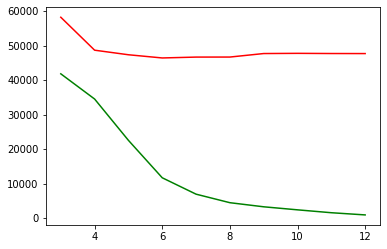

In [140]:
max_depths = [i+3 for i in range(10)]
mdl = ID3_A_regressor()
rmse_train = []
rmse_test = []
for max_depth in max_depths:
  mdl.fit(X_train,Y_train,max_depth = max_depth)
  rmse_train.append(mse(Y_train,mdl.predict(X_train))**.5)
  rmse_test.append(mse(Y_test,mdl.predict(X_test))**.5)
plt.plot(max_depths,rmse_test,'r')
plt.plot(max_depths,rmse_train,'g')

In [ ]:
m_inst = [30-5*i for i in range(6)]
mdl = ID3_A_regressor()
rmse_train = []
rmse_test = []
for min_instances in m_inst:
  mdl.fit(X_train,Y_train,min_instances=min_instances)
  rmse_train.append(mse(Y_train,mdl.predict(X_train))**.5)
  rmse_test.append(mse(Y_test,mdl.predict(X_test))**.5)




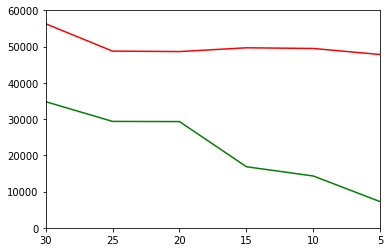

In [153]:
plt.plot(m_inst,rmse_test,'r')
plt.plot(m_inst,rmse_train,'g')
plt.axis([30,5,0,60000])
plt.show()

In [121]:
from numpy.linalg import norm


class Kmeans:

    def __init__(self, n_clusters=3, max_iter=500, metric="euclidean", random_state = 134):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.metric = metric
        self.random_state = random_state

    def initialize_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def compute_distance(self, X, centroids, metric):
        distance = np.zeros((X.shape[0], self.n_clusters))
        if(metric == 'euclidean'):
          for k in range(self.n_clusters):
              row_norm = norm(X - centroids[k, :], axis=1)
              distance[:, k] = np.square(row_norm)
        elif(metric == 'manhattan'):
          for k in range(self.n_clusters):
              diff = X - centroids[k, :]
              distance[:, k] = np.sum(abs(diff),axis=1)
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))
    
    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids, self.metric)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)
  

    def predict(self, X):
        distance = self.compute_distance(X, self.centroids,self.metric)
        return self.find_closest_cluster(distance)

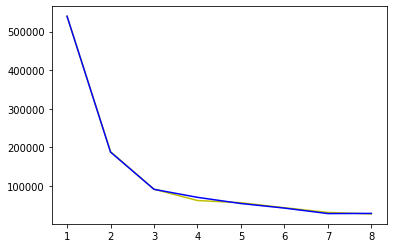

In [122]:
k_values = [i+1 for i in range(8)]
wcss_values_euc = []
wcss_values_manh = []

for k in k_values:
  kmodel = Kmeans(metric = 'manhattan',n_clusters = k,max_iter=10000)
  kmodel.fit(np.array(X_train))
  wcss_values_manh.append(kmodel.compute_sse(np.array(X_train),kmodel.labels, kmodel.centroids))
for k in k_values:
  kmodel = Kmeans(metric = 'euclidean',n_clusters = k,max_iter=10000)
  kmodel.fit(np.array(X_train))
  wcss_values_euc.append(kmodel.compute_sse(np.array(X_train),kmodel.labels, kmodel.centroids))

plt.plot(k_values,wcss_values_manh,'y')
plt.plot(k_values,wcss_values_euc,'b')

In [123]:
class forest():

  def __init__(self,tree_class,n_trees=3,max_depth= 5,min_instances=10,tol = 0):
    self.tree_class = tree_class
    self.n_trees = n_trees
    self.max_depth = max_depth
    self.min_instances = min_instances
    self.tol = tol
    self.trees = []
    self.labels = None
    self.clustering_model = None

  def fit_dec_tree(self,X,y):
    model = self.tree_class()
    model.fit(X,y,self.max_depth, self.tol, self.min_instances)
    return model

  def fit(self,X,y,clustering_metric = 'euclidean',max_iter=500):
    self.clustering_model = Kmeans(metric = clustering_metric,n_clusters = self.n_trees,max_iter=max_iter)
    self.clustering_model.fit(np.array(X))
    self.labels = self.clustering_model.predict(np.array(X))
    self.trees = [self.fit_dec_tree(X,y) for i in range(self.n_trees)]

  def predict(self,X):
    y_pred = []
    closest_cluster = self.clustering_model.predict(np.array(X))
    for i in range(X.shape[0]):
      trial = self.trees[closest_cluster[i]].predict(X.iloc[[i]])
      y_pred.append(trial[i])
    return y_pred

In [124]:
X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)

In [125]:
cart_forest = forest(CART_regressor,n_trees = 3,max_depth = 10)
cart_forest.fit(X_train,Y_train,max_iter=3000)
y_cart_forest_train_pred = cart_forest.predict(X_train)


In [126]:
mse(Y_train,y_cart_forest_train_pred)**0.5

16614.473829490147

In [127]:
id3_a_forest = forest(ID3_A_regressor,n_trees = 3,max_depth = 10)
id3_a_forest.fit(X_train,Y_train,max_iter=3000)
y_id3_a_forest_train_pred = id3_a_forest.predict(X_train)

In [128]:
mse(Y_train,y_id3_a_forest_train_pred)**0.5

14287.405786583082

In [129]:
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

In [130]:
y_test_cart_forest_pred = cart_forest.predict(X_test)
r2_score(Y_test, y_test_cart_forest_pred)

0.6976824398269805

In [131]:
y_test_id3_a_forest_pred = id3_a_forest.predict(X_test)
r2_score(Y_test, y_test_id3_a_forest_pred)

0.7318993739112811

In [132]:
# K Fold Cross Validation

class k_fold:
    
    def __init__(self):
        pass
    
    
    def cross(self, df):
        k=5
        min_key = 5

        
        fig = plt.figure()
        plt.xlabel('No. of splits')
        plt.ylabel('Error')
        
        while(k<=len(df)):
            self.n_splits = k
            n= (len(df) // self.n_splits)
            total_error = 0
            
            for i in range(self.n_splits):
                validation = df[(i*n):((i+1)*n)]
                train = pd.concat([df[:(i*n)],df[((i+1)*n):]])
                total_error += self.model(train ,validation)
            
            
            total_error = total_error/k

            if(k==5):
            	min_error = total_error
            else:
            	if(total_error<min_error):
            		min_error = total_error
            		min_key = k

            fig = plt.scatter(k,total_error,color='g')
            k= k+1
        
        return (fig,min_key,min_error)    


    
    def model(self, train, validation):

        train_x = np.array(train.iloc[:,:-1])
        train_y = train.iloc[:,-1]

        validation_x = np.array(validation.iloc[:,:-1])
        validation_y = validation.iloc[:,-1]
        

        #Making estimates from the validation set
        from sklearn.linear_model import LinearRegression
        clf = LinearRegression()
        clf.fit(train_x,train_y)
        pred_y = clf.predict(validation_x)
        
        error = np.square(np.subtract(validation_y,pred_y)).mean()
        return error

In [135]:
class model:
    
    def __init__(self):
        pass
    
    def algo(self, train_data, test_data):
        
        k_cross = k_fold()
        plot, correct_K, correct_error = k_cross.cross(train_data)

        print("Estimated Error Rate = ",correct_error," with K = ",correct_K)
        plt.show(plot)

        train_x = np.array(train_data.iloc[:,:-1])
        train_y = train_data.iloc[:,-1]
        test_x = np.array(test_data.iloc[:,:-1])
        test_y = test_data.iloc[:,-1]

        from sklearn.linear_model import LinearRegression
        clf = LinearRegression()
        clf.fit(train_x,train_y)
        pred_y = clf.predict(test_x)

        actual_error_rate = np.square(np.subtract(test_y,pred_y)).mean()
        print("Actual Error Rate  = ",actual_error_rate)

Estimated Error Rate =  8.773305817059923  with K =  15


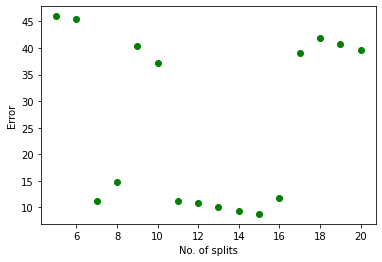

Actual Error Rate  =  12126584091.240128


In [136]:
cross_validation = model()

#Dividing the train and test data
train = df.iloc[:20,:]
test = df.iloc[20:,:]

cross_validation.algo(train, test)